In [2]:
import sys
sys.path.append("../../")
sys.path.append("../")

import paradime.routines
import paradime.utils
import torchvision

from openTSNE import TSNE as OpenTSNE
from sklearn.manifold import TSNE as ScikitTSNE
from sklearn.manifold import trustworthiness

mnist = torchvision.datasets.MNIST(
    '../../data',
    train=True,
    download=True,
)
mnist_data = mnist.data.reshape(-1, 28*28) / 255.
num_items = 5000

In [3]:
tsne = {}

In [5]:
tsne["open"] = OpenTSNE(perplexity=100).fit(mnist_data[:num_items].numpy())

Note that we have already flattened the image data into vectors of length 784 and normalized the values to a range between 0 and 1. ``num_items`` is the size of the MNIST subset that we are going to use for training our routine.

## Setting Up a Predefined Routine

We now create an instance of a parametric version of the t-SNE algorithm:

In [6]:
dr = paradime.routines.ParametricTSNE(
    perplexity=100,
    dataset=mnist_data[:num_items],
    epochs=40,
    use_cuda=True,
    verbose=True,
)

2022-09-12 13:34:13,352: Registering dataset.


In [7]:
dr.train()

2022-09-12 13:34:26,490: Adding entry 'pca' to dataset.
2022-09-12 13:34:26,491: Computing global relations 'rel'.
2022-09-12 13:34:26,493: Indexing nearest neighbors.
2022-09-12 13:34:51,010: Calculating probabilities.
2022-09-12 13:34:51,842: Beginning training phase 'pca_init'.
2022-09-12 13:34:53,572: Loss after epoch 0: 27.914062321186066
2022-09-12 13:34:53,947: Loss after epoch 5: 0.19892266299575567
2022-09-12 13:34:54,261: Beginning training phase 'embedding'.
2022-09-12 13:34:54,753: Loss after epoch 0: 0.04910902353003621
2022-09-12 13:34:57,269: Loss after epoch 5: 0.03771051112562418
2022-09-12 13:34:59,829: Loss after epoch 10: 0.035503369057551026
2022-09-12 13:35:02,425: Loss after epoch 15: 0.03401176701299846
2022-09-12 13:35:04,979: Loss after epoch 20: 0.03258104436099529
2022-09-12 13:35:07,517: Loss after epoch 25: 0.032046356005594134
2022-09-12 13:35:10,114: Loss after epoch 30: 0.031288295751437545
2022-09-12 13:35:12,665: Loss after epoch 35: 0.031142274150624

In [8]:
tsne["paradime"] = dr.apply(mnist_data[:num_items]).numpy()

In [10]:
tsne["sklearn"] = ScikitTSNE(
    perplexity=100,
    init="pca",
).fit_transform(mnist_data[:num_items].numpy())

c:\Users\Andreas\miniconda3\envs\ml\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
c:\Users\Andreas\miniconda3\envs\ml\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


In [12]:
trustworthiness(
    mnist_data[:num_items].numpy(),
    tsne["sklearn"],
    n_neighbors=5,
)

0.985505032051282

In [13]:
trustworthiness(
    mnist_data[:num_items].numpy(),
    tsne["paradime"],
    n_neighbors=5,
)

0.9281994631410256

In [14]:
trustworthiness(
    mnist_data[:num_items].numpy(),
    tsne["open"],
    n_neighbors=5,
)

0.9826397435897436

<AxesSubplot:>

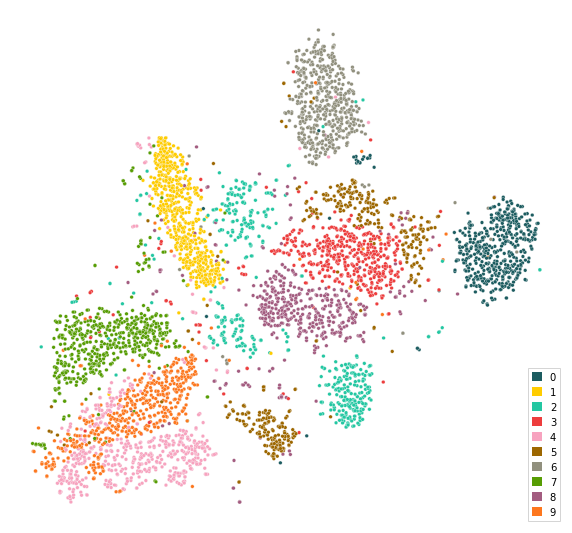

In [17]:
paradime.utils.plotting.scatterplot(tsne["open"], labels=mnist.targets[:num_items])

<AxesSubplot:>

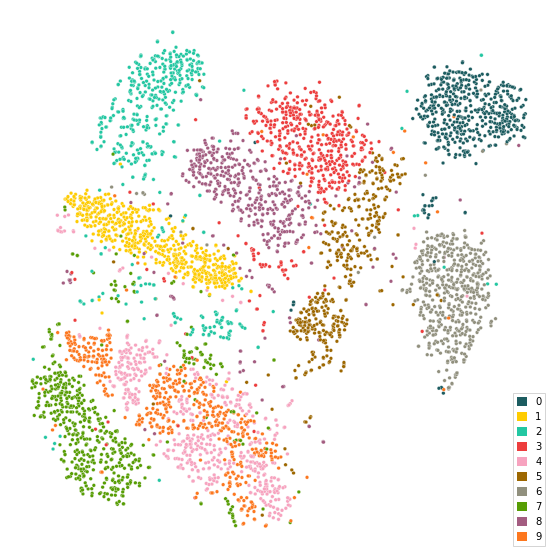

In [18]:
paradime.utils.plotting.scatterplot(tsne["sklearn"], labels=mnist.targets[:num_items])

<AxesSubplot:>

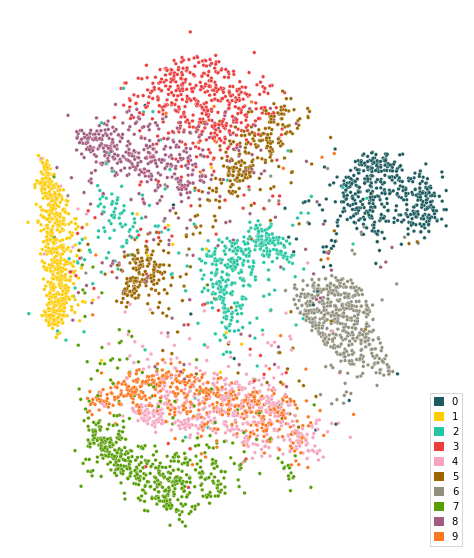

In [19]:
paradime.utils.plotting.scatterplot(tsne["paradime"], labels=mnist.targets[:num_items])

In [27]:
p = paradime.relations.PDist(
    transform=[
        paradime.transforms.PerplexityBasedRescale(
            perplexity=100,
        ),
        paradime.transforms.Symmetrize(),
        paradime.transforms.Normalize(),
        paradime.transforms.ToSquareTensor(),
    ]
).compute_relations(mnist_data[:num_items])

In [31]:
q = {}

for k in tsne:
    q[k] = paradime.relations.PDist(
        transform=[
            paradime.transforms.StudentTTransform(
                alpha=1.0,
            ),
            paradime.transforms.Normalize(),
            paradime.transforms.ToSquareTensor(),
        ]
    ).compute_relations(tsne[k]).data


In [36]:
paradime.loss.kullback_leibler_div(
    p.data, q["open"]
) * num_items

tensor(0.9549, dtype=torch.float64)

In [37]:
paradime.loss.kullback_leibler_div(
    p.data, q["sklearn"]
) * num_items

tensor(0.9004, dtype=torch.float64)

In [38]:
paradime.loss.kullback_leibler_div(
    p.data, q["paradime"]
) * num_items

tensor(1.2604, dtype=torch.float64)

In [54]:
tsne_global_rel = paradime.relations.PDist(
    transform=[
        paradime.transforms.PerplexityBasedRescale(
            perplexity=100, bracket=[0.001, 1000]
        ),
        paradime.transforms.Symmetrize(),
        paradime.transforms.Normalize(),
    ]
)

tsne_batch_rel = paradime.relations.DifferentiablePDist(
    transform=[
        paradime.transforms.StudentTTransform(alpha=1.0),
        paradime.transforms.Normalize(),
        paradime.transforms.ToSquareTensor(),
    ]
)

pca = dr.dataset.data["pca"]

tsne_init = paradime.dr.TrainingPhase(
    name="pca_init",
    loss=paradime.loss.PositionLoss(position_key="pca"),
    batch_size=500,
    epochs=10,
    learning_rate=0.01,
)

tsne_main = paradime.dr.TrainingPhase(
    name="embedding",
    loss=paradime.loss.RelationLoss(
        loss_function=paradime.loss.kullback_leibler_div
    ),
    batch_size=500,
    epochs=40,
    learning_rate=0.01,
    report_interval=5,
)

pd_tsne = paradime.dr.ParametricDR(
    global_relations=tsne_global_rel,
    batch_relations=tsne_batch_rel,
    in_dim=28*28,
    out_dim=2,
    hidden_dims=[100,50],
    dataset=mnist_data[:num_items],
    use_cuda=True,
    verbose=True,
)
pd_tsne.add_to_dataset({"pca": pca})
pd_tsne.add_training_phase(tsne_init)
pd_tsne.add_training_phase(tsne_main)

2022-09-12 14:14:36,783: Registering dataset.
2022-09-12 14:14:36,797: Adding entry 'pca' to dataset.


In [55]:
pd_tsne.train()

2022-09-12 14:14:40,087: Computing global relations 'rel'.
2022-09-12 14:14:40,088: Calculating pairwise distances.
2022-09-12 14:14:51,287: Calculating probabilities.
2022-09-12 14:14:57,706: Beginning training phase 'pca_init'.
2022-09-12 14:14:57,826: Loss after epoch 0: 20.309013307094574
2022-09-12 14:14:58,187: Loss after epoch 5: 0.17209964711219072
2022-09-12 14:14:58,728: Beginning training phase 'embedding'.
2022-09-12 14:15:07,459: Loss after epoch 0: 0.049269783663074954
2022-09-12 14:15:50,735: Loss after epoch 5: 0.039009597912144055
2022-09-12 14:16:35,850: Loss after epoch 10: 0.03595826214247164
2022-09-12 14:17:20,787: Loss after epoch 15: 0.03460618999324702
2022-09-12 14:18:04,897: Loss after epoch 20: 0.03286616997271041
2022-09-12 14:18:52,255: Loss after epoch 25: 0.032457397416037176
2022-09-12 14:19:45,369: Loss after epoch 30: 0.032334874604363066
2022-09-12 14:20:37,535: Loss after epoch 35: 0.030612460792545496


<AxesSubplot:>

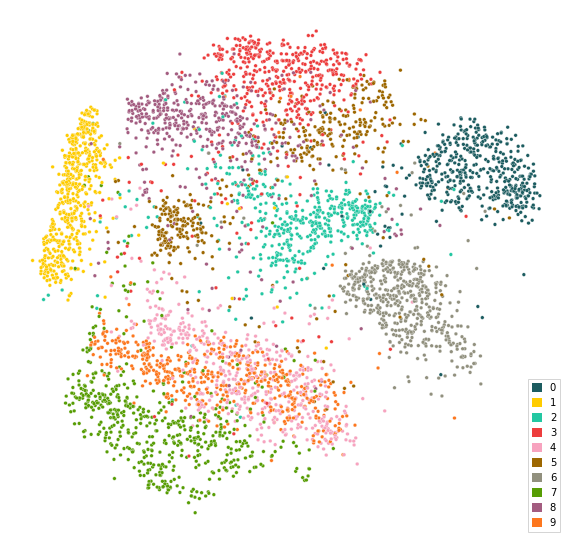

In [56]:
paradime.utils.plotting.scatterplot(pd_tsne.apply(mnist_data[:num_items]),labels=mnist.targets[:num_items])

In [57]:
q["paradime2"] = paradime.relations.PDist(
        transform=[
            paradime.transforms.StudentTTransform(
                alpha=1.0,
            ),
            paradime.transforms.Normalize(),
            paradime.transforms.ToSquareTensor(),
        ]
    ).compute_relations(pd_tsne.apply(mnist_data[:num_items])).data


In [59]:
from umap import ParametricUMAP